# Neural Net to recognise cloud types

In [1]:
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

from utilities import get_dataset_partitions_tf
print(tf.version.VERSION)

2.3.0


In [19]:
batch_size = 32
epochs = 8
training_split, val_split, test_split = 0.75, 0.15, 0.1

# parameters to save/load model
model_name = "ccp_epoch8"                  # None if not saving
model_path = "models/" + model_name

In [4]:
ccsn_ds = keras.preprocessing.image_dataset_from_directory(
    'CCSN',
    seed=420,
    image_size=(225, 225),
    batch_size=batch_size
)
print(f"Number of batches: {int(ccsn_ds.cardinality())}")

train_ds, val_ds, test_ds = get_dataset_partitions_tf(
    ccsn_ds,
    int(ccsn_ds.cardinality()),
    training_split,
    val_split,
    test_split,
)

class_names = ccsn_ds.class_names
num_classes = len(class_names)
print(f"class names:\n{class_names}")


Found 2543 files belonging to 11 classes.
Number of batches: 80
class names:
['Ac', 'As', 'Cb', 'Cc', 'Ci', 'Cs', 'Ct', 'Cu', 'Ns', 'Sc', 'St']


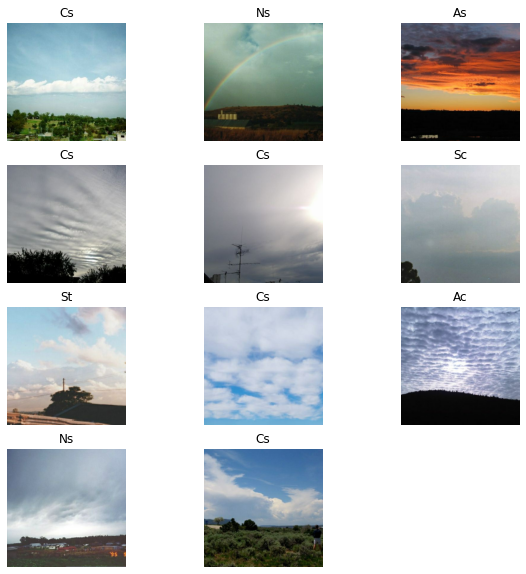

In [5]:
# Ploting some samples from our dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(11):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# scaling the pixel values to fit in [0, 1] interval
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(225, 225, 3))

In [16]:
def create_model(lr=0.001):
    model = Sequential([
        normalization_layer,
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPool2D(3, strides=3, padding="same"),
        layers.Conv2D(32, 5, padding="same", activation="relu"),
        layers.Conv2D(64, 5, strides=3, padding="same", activation="relu"),
        layers.MaxPool2D(3, strides=3, padding="same"),
        layers.Flatten(),
        layers.Dense(
            128, 
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(0.02)
        ),
        layers.Dense(num_classes)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.metrics.SparseCategoricalAccuracy()]
    )

    return model
my_model = None
my_model = create_model(lr=0.0005)
my_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 225, 225, 3)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 225, 225, 16)      448       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 225, 225, 16)      2320      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 75, 75, 32)        12832     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 25, 25, 64)        51264     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 9, 9, 64)         

In [17]:
history = my_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/8
60/60 [==============================] - 80s 1s/step - loss: 4.0527 - sparse_categorical_accuracy: 0.1645 - val_loss: 2.5519 - val_sparse_categorical_accuracy: 0.2125
Epoch 2/8
60/60 [==============================] - 80s 1s/step - loss: 2.3365 - sparse_categorical_accuracy: 0.2365 - val_loss: 2.2506 - val_sparse_categorical_accuracy: 0.2708
Epoch 3/8
60/60 [==============================] - 79s 1s/step - loss: 2.1868 - sparse_categorical_accuracy: 0.2738 - val_loss: 2.1289 - val_sparse_categorical_accuracy: 0.2865
Epoch 4/8
60/60 [==============================] - 87s 1s/step - loss: 2.1215 - sparse_categorical_accuracy: 0.2817 - val_loss: 2.1635 - val_sparse_categorical_accuracy: 0.2891
Epoch 5/8
60/60 [==============================] - 82s 1s/step - loss: 2.0786 - sparse_categorical_accuracy: 0.3085 - val_loss: 2.0335 - val_sparse_categorical_accuracy: 0.3515
Epoch 6/8
60/60 [==============================] - 96s 2s/step - loss: 2.0324 - sparse_categorical_accuracy: 0.3137

In [20]:
my_model.save(model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/ccp_epoch8\assets


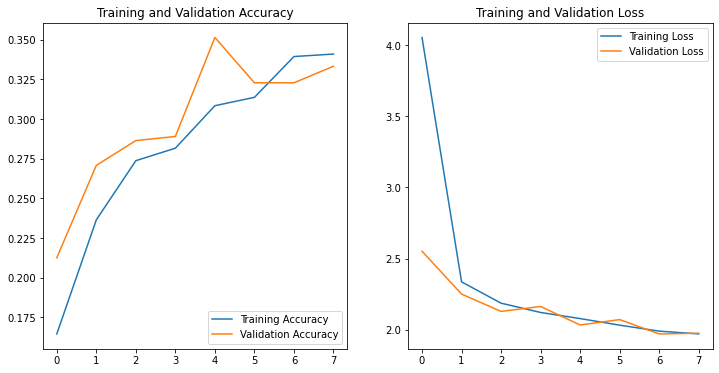

In [18]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()